<a href="https://colab.research.google.com/github/Mabalzich/MLFinalProject/blob/main/MNITSTGNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [67]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import numpy as np
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt

In [68]:
class GraphNet(nn.Module):
    def __init__(self, image_size = 28, pred_edge = False):
        super(GraphNet, self).__init__()
        self.pred_edge = pred_edge
        N = image_size ** 2 # Number of pixels in the image
        self.fc = nn.Linear(N, 10, bias = False)
        # Create the adjacency matrix of size (N X N)
        if pred_edge:
            # Learn the adjacency matrix (learn to predict the edge between any pair of pixels)
            col, row = np.meshgrid(np.arange(image_size), np.arange(image_size)) # (28 x 28) Explanation: https://www.geeksforgeeks.org/numpy-meshgrid-function/
            coord = np.stack((col, row), axis = 2).reshape(-1, 2)  # (784 x 2)
            coord_normalized = (coord - np.mean(coord, axis = 0)) / (np.std(coord, axis = 0) + 1e-5) # Normalize the matrix
            coord_normalized = torch.from_numpy(coord_normalized).float() # (784 x 2)
            adjacency_matrix = torch.cat((coord_normalized.unsqueeze(0).repeat(N, 1,  1),
                                    coord_normalized.unsqueeze(1).repeat(1, N, 1)), dim=2) # (784 x 784 x 4)
            self.pred_edge_fc = nn.Sequential(nn.Linear(4, 64),
                                              nn.ReLU(), 
                                              nn.Linear(64, 1),
                                              nn.Tanh())
            self.register_buffer('adjacency_matrix', adjacency_matrix) # not to be considered a model paramater that is updated during training
        else:
            # Use a pre-computed adjacency matrix
            A = self.precompute_adjacency_images(image_size)
            self.register_buffer('A', A) # not to be considered a model paramater that is updated during training

    def forward(self, x):
        '''
        x: image (batch_size x 1 x image_width x image_height)
        '''
        B = x.size(0) # 64
        if self.pred_edge:
            self.A = self.pred_edge_fc(self.adjacency_matrix).squeeze() # (784 x 784) --> predicted edge map

        avg_neighbor_features = (torch.bmm(self.A.unsqueeze(0).expand(B, -1, -1), 
                                            x.view(B, -1, 1)).view(B, -1)) # (64 X 784)
        return self.fc(avg_neighbor_features)

    @staticmethod
    # Static method knows nothing about the class and just deals with the parameters.
    def precompute_adjacency_images(image_size):
        print('precompute_adjacency_images')
        col, row = np.meshgrid(np.arange(image_size), np.arange(image_size)) # (28 x 28) Explanation: https://www.geeksforgeeks.org/numpy-meshgrid-function/
        coord = np.stack((col, row), axis = 2).reshape(-1, 2) / image_size # (784 x 2) --> normalize
        dist = cdist(coord, coord) # compute distance between every pair of pixels
        sigma = 0.05 * np.pi # width of the Gaussian (can be a hyperparameter while training a model)
        A = np.exp(-dist / sigma ** 2) # adjacency matrix of spatial similarity
        A[A < 0.01] = 0 # suppress values less than 0.01
        A = torch.from_numpy(A).float()

        # Normalization as per (Kipf & Welling, ICLR 2017)
        D = A.sum(1)  # nodes degree (N,)
        D_hat = (D + 1e-5) ** (-0.5)
        A_hat = D_hat.view(-1, 1) * A * D_hat.view(1, -1)  # N,N

        # Some additional trick I found to be useful
        A_hat[A_hat > 0.0001] = A_hat[A_hat > 0.0001] - 0.2

        print(A_hat[:10, :10])
        return A_hat

In [69]:
def train(model, train_loader, optimizer, epoch):
    accuracy = []
    f1score = []
    precision = []
    recall = []
    p_inter = [[0,0] for x in range(10)]
    r_inter = [[0,0] for x in range(10)]
    correct = 0
    total = 0
    next = 1
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = model(data)
        # Cross entropy loss
        loss = F.cross_entropy(output, target)
        loss.backward()
        optimizer.step()
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()
        for p, t, c in zip(pred,target,pred.eq(target.view_as(pred))):
          p_inter[p.item()][0] += c.item()
          p_inter[p.item()][1] += 1
          r_inter[p.item()][0] += c.item()
          r_inter[t.item()][1] += 1
        total += len(data)
        if total > (next * 10000):
          next += 1
          #macro averaging
          prec = sum([1.0 * x[0]/x[1] for x in p_inter]) / 10.0
          rec = sum([1.0 * x[0]/x[1] for x in r_inter]) / 10.0
          print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}, Accuracy: ({:.2f}%) F1 Score: ({:.2f}%) Precision: ({:.2f}%) Recall: ({:.2f}%)'.format(
              epoch, batch_idx * len(data), len(train_loader.dataset),
              100. * batch_idx / len(train_loader), loss.item(),
              100. * correct / total, 100. * 2*((prec*rec)/(prec+rec+1e-12)), 100. * prec, 100. * rec))
    print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}, Accuracy: ({:.2f}%) F1 Score: ({:.2f}%) Precision: ({:.2f}%) Recall: ({:.2f}%)'.format(
              epoch, batch_idx * len(data), len(train_loader.dataset),
              100. * batch_idx / len(train_loader), loss.item(),
              100. * correct / total, 100. * 2*((prec*rec)/(prec+rec+1e-12)), 100. * prec, 100. * rec))
    prec = sum([1.0 * x[0]/x[1] for x in p_inter]) / 10.0
    rec = sum([1.0 * x[0]/x[1] for x in r_inter]) / 10.0
    return 1.0 * correct / total, 2*((prec*rec)/(prec+rec+1e-12)), prec, rec

In [70]:
def test(model, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            output = model(data)
            test_loss += F.cross_entropy(output, target, reduction='sum').item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
    test_loss /= len(test_loader.dataset)
    print(
        '\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
            test_loss, correct, len(test_loader.dataset),
            100. * correct / len(test_loader.dataset)))
    return 1. * correct / len(test_loader.dataset)

In [71]:
bsize = 32
learningrate = 0.0001
epochs = 100

In [72]:
def main():
    train_loader = torch.utils.data.DataLoader(
        datasets.MNIST('../data', train=True, download=True,
                       transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize((0.1307,), (0.3081,))
                       ])),
        batch_size=bsize, shuffle=True)
    test_loader = torch.utils.data.DataLoader(
        datasets.MNIST('../data', train=False, transform=transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.1307,), (0.3081,))
        ])),
        batch_size=bsize, shuffle=False)    
    
    model = GraphNet()

    optimizer = optim.SGD(model.parameters(), lr = learningrate, weight_decay = 1e-4)

    print('number of trainable parameters: %d' %
          np.sum([np.prod(p.size()) if p.requires_grad else 0 for p in model.parameters()]))

    accuracy = []
    f1scores = []
    precision = []
    recall = []
    val_accuracy = []
    for epoch in range(1, epochs + 1):
      acc, f1, prec, rec = train(model, train_loader, optimizer, epoch)
      accuracy.append(acc)
      f1scores.append(f1)
      precision.append(prec)
      recall.append(rec)
      val_accuracy.append(test(model, test_loader))
    
    # Plot training accuracy
    plt.plot([item for item in accuracy if item is not None], 'o-', label='GNN')

    plt.title('training accuracy')
    plt.ylabel('training accuracy')
    plt.xlabel('epoch')
    plt.legend(loc='best')
    plt.show()

    # Plot validation accuracy
    plt.plot([item for item in val_accuracy if item is not None], 'o-', label='GNN')

    plt.title('validation accuracy')
    plt.ylabel('validation accuracy')
    plt.xlabel('epoch')
    plt.legend(loc='best')
    plt.show()

    # Plot f1 score
    plt.plot([item for item in f1scores if item is not None], 'o-', label='GNN')

    plt.title('f1 score')
    plt.ylabel('f1 score')
    plt.xlabel('epoch')
    plt.legend(loc='best')
    plt.show()

    # Plot precision
    plt.plot([item for item in precision if item is not None], 'o-', label='GNN')

    plt.title('precision')
    plt.ylabel('precision')
    plt.xlabel('epoch')
    plt.legend(loc='best')
    plt.show()

    # Plot f1 score
    plt.plot([item for item in recall if item is not None], 'o-', label='GNN')

    plt.title('recall')
    plt.ylabel('recall')
    plt.xlabel('epoch')
    plt.legend(loc='best')
    plt.show()


precompute_adjacency_images
tensor([[ 0.3400, -0.0852, -0.1736, -0.1938,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000],
        [-0.0852,  0.2413, -0.0987, -0.1763, -0.1944,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000],
        [-0.1736, -0.0987,  0.2207, -0.1015, -0.1768, -0.1946,  0.0000,  0.0000,
          0.0000,  0.0000],
        [-0.1938, -0.1763, -0.1015,  0.2166, -0.1020, -0.1770, -0.1946,  0.0000,
          0.0000,  0.0000],
        [ 0.0000, -0.1944, -0.1768, -0.1020,  0.2166, -0.1020, -0.1770, -0.1946,
          0.0000,  0.0000],
        [ 0.0000,  0.0000, -0.1946, -0.1770, -0.1020,  0.2166, -0.1020, -0.1770,
         -0.1946,  0.0000],
        [ 0.0000,  0.0000,  0.0000, -0.1946, -0.1770, -0.1020,  0.2166, -0.1020,
         -0.1770, -0.1946],
        [ 0.0000,  0.0000,  0.0000,  0.0000, -0.1946, -0.1770, -0.1020,  0.2166,
         -0.1020, -0.1770],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000, -0.1946, -0.1770, -0.1020,
          0.2166, -

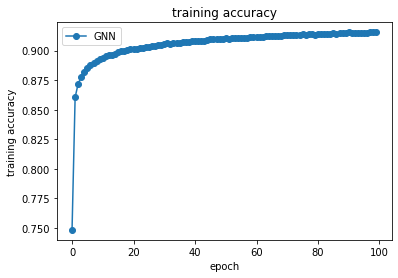

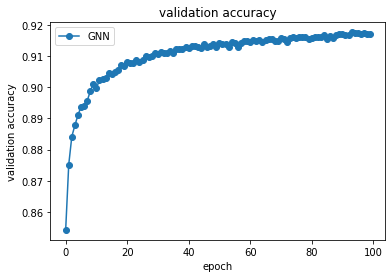

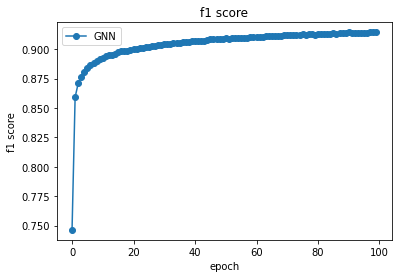

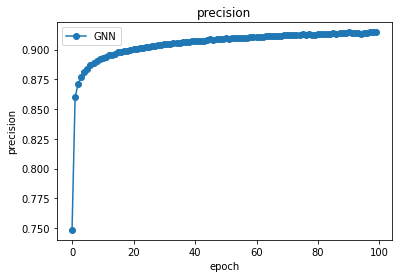

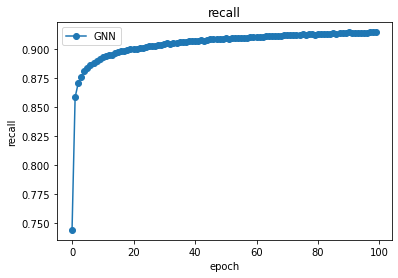

In [73]:
if __name__ == '__main__':
    main()